In [ ]:
# STEP 1: Install Required Libraries
!pip install -q opencv-python-headless matplotlib


In [ ]:
# 📚 Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files
from PIL import Image, ImageDraw
import io
import ipywidgets as widgets
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


In [ ]:
# Let user choose input mode
input_mode = widgets.Dropdown(
    options=["Upload Image", "Use Webcam", "Draw Digit"],
    value="Upload Image",
    description="Choose Input:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)
display(input_mode)


Dropdown(description='Choose Input:', layout=Layout(width='50%'), options=('Upload Image', 'Use Webcam', 'Draw…

In [ ]:
# Upload trained CNN model
print("📁 Upload your trained model (.h5 file)")
model_file = files.upload()
model_path = list(model_file.keys())[0]
model = load_model(model_path)
print("✅ Model loaded!")


📁 Upload your trained model (.h5 file)


Saving mnist_cnn_model.h5 to mnist_cnn_model (1).h5
✅ Model loaded!


In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


In [ ]:
def get_input_image():
    mode = input_mode.value
    if mode == "Upload Image":
        print("🖼️ Upload an image of a digit (jpg/png)")
        uploaded = files.upload()
        path = list(uploaded.keys())[0]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        return img

    elif mode == "Use Webcam":
        print("📷 Capturing image from webcam...")
        try:
            photo_path = take_photo()
            img = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)
            return img
        except Exception as e:
            print("❌ Webcam error:", e)
            return None

    elif mode == "Draw Digit":
        print("✍️ Draw on the canvas below...")

        canvas_width = 280
        canvas_height = 280
        canvas = Image.new("L", (canvas_width, canvas_height), 0)
        draw = ImageDraw.Draw(canvas)

        @widgets.interact(x=widgets.IntSlider(0, 0, canvas_width-1),
                          y=widgets.IntSlider(0, 0, canvas_height-1))
        def draw_point(x=0, y=0):
            draw.ellipse((x, y, x+20, y+20), fill=255)
            plt.imshow(canvas, cmap='gray')
            plt.axis('off')
            plt.show()

        print("🔁 After drawing, re-run the next cell to predict.")
        canvas.save("drawn_digit.jpg")
        return cv2.imread("drawn_digit.jpg", cv2.IMREAD_GRAYSCALE)


In [ ]:
def predict_digit(img):
    if img is None:
        print("⚠️ No image to process.")
        return

    # Invert & preprocess
    img = cv2.bitwise_not(img)
    img = cv2.resize(img, (28, 28))
    img = img / 255.0
    img_input = img.reshape(1, 28, 28, 1)

    prediction = model.predict(img_input)
    digit = np.argmax(prediction)
    confidence = np.max(prediction) * 100

    # Show result
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {digit} ({confidence:.2f}%)")
    plt.show()

    print(f"✅ This looks like a **{digit}** with {confidence:.2f}% confidence.")


🖼️ Upload an image of a digit (jpg/png)


Saving WhatsApp Image 2025-06-16 at 23.29.13.jpeg to WhatsApp Image 2025-06-16 at 23.29.13.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


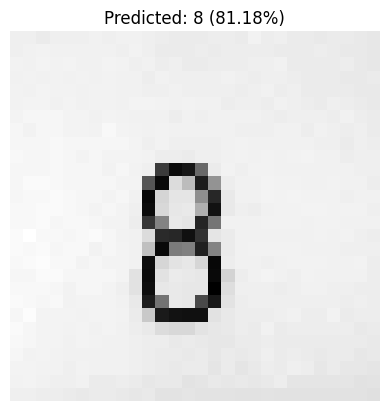

✅ This looks like a **8** with 81.18% confidence.


In [ ]:
# Get image and predict
input_image = get_input_image()
predict_digit(input_image)
